In [24]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

URL = 'https://kolesa.kz/cars/'
HEADERS = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
          'accept':'*/*'}

data = {'name':[],'price':[],'text':[],'link':[],'date':[],'city':[]}
def get_html(url, params = None):
    r = requests.get(url,headers = HEADERS,params = params)
    return r

    


def get_content(html):
    soup = BeautifulSoup(html,'html.parser')
    items = soup.find_all('div',class_ ='a-info-side col-right-list')
    #print(items)
    for item in items:
        data['name'].append(item.find('a',class_ ="list-link ddl_product_link").get_text().strip())
        data['price'].append(item.find('span',class_ ="price").get_text().strip())
        data['text'].append(item.find('div',class_ ="a-search-description").get_text().strip())
        data['link'].append(item.find('a',class_ ="list-link ddl_product_link").get('href').strip())
        data['city'].append(item.find('div',class_ ='list-region').get_text().strip())
        data['date'].append(item.find('span',class_ ='date').get_text().strip())
        #data['clicks'].append(item.find('span',class_ ='nb-views-int').get_text())
    
        
def parse():
    #300 страниц
    for i in range(1,500):
        html = get_html(URL + '?page='+str(i))

        if html.status_code == 200:

            get_content(html.text)

        else:
            print('Error: 1')
        
        
parse()

df = pd.DataFrame(data)
df.head()


,name,price,text,link,date,city
0,Volkswagen Sharan,1 900 000 ₸,"2002 г., Б/у минивэн, 1.9 л, дизель, КПП автом...",/a/show/117546900,19 сентября,Шымкент
1,Kia Rio,5 200 000 ₸,"2013 г., Б/у седан, 1.6 л, бензин, КПП механик...",/a/show/125374692,19 сентября,Нур-Султан (Астана)
2,Infiniti FX35,5 100 000 ₸,"2003 г., Б/у кроссовер, 3.5 л, бензин, КПП авт...",/a/show/122322579,19 сентября,Караганда
3,Volkswagen Golf,3 000 000 ₸,"1998 г., Б/у хэтчбек, 1.6 л, бензин, КПП автом...",/a/show/125705583,19 сентября,Шымкент
4,Toyota Camry,5 000 000 ₸,"2010 г., Б/у седан, 2.5 л, бензин, КПП автомат...",/a/show/125705381,19 сентября,Нур-Султан (Астана)


In [34]:
df.link = 'https://kolesa.kz/' + df.link
df['id'] = [i[-1] for i in df.link.str.split('/').values]
df['year'] = [re.findall(r'\d+',i[0])[0] for i in df.text.str.split(',').values]
df['quality'] = [i[1].split(' ')[1] for i in df.text.str.split(',').values]
df['type'] = [i[1].split(' ')[2] for i in df.text.str.split(',').values]
df['volume_l'] = [i[2].split(' ')[1] for i in df.text.str.split(',').values]
df['fuel_type'] = [i[3] for i in df.text.str.split(',').values]
df['Kpp'] = [i[4]  if len(i)>4  else'None' for i in df.text.str.split(',').values]
df['price'] = [''.join(i) for i in df.price.str.findall(r'\d+')]
df['price'] = df['price'].astype(int)
df['year'] = df['year'].astype(int)

df = df[['id','name','price','year','quality','type','volume_l','fuel_type','Kpp','text','date','city','link']]

df.head()

,id,name,price,year,quality,type,volume_l,fuel_type,Kpp,text,date,city,link
0,117546900,Volkswagen Sharan,1900000,2002,Б/у,минивэн,1.9,дизель,КПП автомат,"2002 г., Б/у минивэн, 1.9 л, дизель, КПП автом...",19 сентября,Шымкент,https://kolesa.kz//a/show/117546900
1,125374692,Kia Rio,5200000,2013,Б/у,седан,1.6,бензин,КПП механика,"2013 г., Б/у седан, 1.6 л, бензин, КПП механик...",19 сентября,Нур-Султан (Астана),https://kolesa.kz//a/show/125374692
2,122322579,Infiniti FX35,5100000,2003,Б/у,кроссовер,3.5,бензин,КПП автомат,"2003 г., Б/у кроссовер, 3.5 л, бензин, КПП авт...",19 сентября,Караганда,https://kolesa.kz//a/show/122322579
3,125705583,Volkswagen Golf,3000000,1998,Б/у,хэтчбек,1.6,бензин,КПП автомат,"1998 г., Б/у хэтчбек, 1.6 л, бензин, КПП автом...",19 сентября,Шымкент,https://kolesa.kz//a/show/125705583
4,125705381,Toyota Camry,5000000,2010,Б/у,седан,2.5,бензин,КПП автомат,"2010 г., Б/у седан, 2.5 л, бензин, КПП автомат...",19 сентября,Нур-Султан (Астана),https://kolesa.kz//a/show/125705381


<AxesSubplot:title={'center':'mean Toyota price by year'}, xlabel='year'>

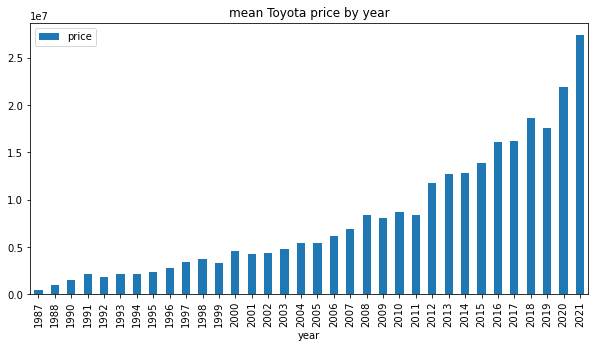

In [36]:
df[df.name.str.find(r'Toyota') == 0][['price','year']].groupby('year').mean().plot(kind = 'bar', title = 'mean Toyota price by year',figsize=(10,5))

In [37]:
df.to_csv('kolesa_19_09_2021.csv')